# Influence of Southern Hemispheres Winds on Northern Hemisphere Ocean via Kelvin and Rossby Waves

In [2]:
import cosima_cookbook as cc

starting distributed client...
<Client: scheduler='tcp://127.0.0.1:34513' processes=8 cores=8>


In [3]:
cc.client

Client Scheduler: tcp://127.0.0.1:34513 Dashboard: http://127.0.0.1:8787,Cluster Workers: 8 Cores: 8 Memory: 20.20 GB


In [8]:
%matplotlib inline

import xarray as xr
import dask.array as da
import numpy as np
import os
from matplotlib import pyplot as plt
import pandas as pd
import netCDF4
import tqdm

In [31]:
import dask.bag
import dask.dataframe as dd
import distributed
from distributed.diagnostics.progressbar import progress

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import rc
rc('animation', html='html5')

In [10]:
import dataset
db = dataset.connect(cc.netcdf_index.database_url)

In [6]:
db

<Database(sqlite:////g/data1/v45/cosima-cookbook/cosima-cookbook.db)>

In [8]:
data = []
for row in tqdm.tqdm_notebook(db['ncfiles'].all(), total = 1000000):
    data.append(row)
df = pd.DataFrame(data)

In [10]:
pat = '(?P<root>[^\d]+)(?P<index>__\d+_\d+)?(?P<indexice>\.\d+\-\d+)?(?P<ext>\.nc)'
repl = lambda m: m.group('root') + ('__\d+_\d+' if m.group('index') else '') + ('.\d+-\d+' if m.group('indexice') else '')+ m.group('ext')
df['basename_pattern'] = df.basename.str.replace(pat, repl)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1187221 entries, 0 to 1187220
Data columns (total 11 columns):
id                  1187221 non-null int64
ncfile              1187221 non-null object
rootdir             1187221 non-null object
configuration       1187221 non-null object
experiment          1187221 non-null object
run                 1187221 non-null object
basename            1187221 non-null object
variable            1187221 non-null object
dimensions          1187221 non-null object
chunking            1187221 non-null object
basename_pattern    1187221 non-null object
dtypes: int64(1), object(10)
memory usage: 99.6+ MB


In [34]:
rows = db.query("select distinct variable from ncfiles where experiment = 'KDS75_PI'")
variables =  [row['variable'] for row in rows]

In [35]:
def lookup_variable(variable):
    rows = db.query("select ncfile from ncfiles where experiment = 'KDS75_PI' and variable = '{}' limit 1".format(variable))
    
    ncfiles = [row['ncfile'] for row in rows]
    if len(ncfiles) == 0:
        return
    
    ncfile = ncfiles[0]

    basename = os.path.basename(ncfile)
    #print(basename)
    dsx = xr.open_dataset(ncfile, decode_times=False)
    try:
        long_name = dsx.get(variable).long_name
    except AttributeError:
        long_name = ''
        
    print(variable, long_name)
        
for variable in tqdm.tqdm_notebook(variables):
    
    lookup_variable(variable)

xt_ocean tcell longitude
yt_ocean tcell latitude
time time
nv vertex number
xu_ocean ucell longitude
yu_ocean ucell latitude
st_ocean tcell zstar depth
st_edges_ocean tcell zstar depth edges
sw_ocean ucell zstar depth
sw_edges_ocean ucell zstar depth edges
geolon_t tracer longitude
geolat_t tracer latitude
geolon_c uv longitude
geolat_c uv latitude
temp Potential temperature
salt Practical Salinity
u i-current
v j-current
pot_rho_0 potential density referenced to 0 dbar
pot_rho_2 potential density referenced to 2000 dbar
wt dia-surface velocity T-points
average_T1 Start time for average period
average_T2 End time for average period
average_DT Length of average period
time_bounds time axis boundaries
mld mixed layer depth determined by density criteria
net_sfc_heating surface ocean heat flux coming through coupler and mass transfer
tx_trans_int_z T-cell i-mass transport vertically summed
ty_trans_int_z T-cell j-mass transport vertically summed
temp_xflux_adv_int_z z-integral of cp*rho*d

In [52]:
with pd.option_context('display.max_rows', None, 'display.latex.longtable', True) as c:
    display(df.pivot_table(index=['variable', 'configuration', 'experiment', 'basename_pattern']).query('variable == "ht"'))


id
variable configuration  experiment                      basename_pattern              
ht       APE-MOM        gfdl_nyf_1080_PI                ocean_grid.nc     5.341534e+05
                        gfdl_nyf_1080_SH                ocean_grid.nc     5.175336e+05
                        gfdl_nyf_1080_UP                ocean_grid.nc     5.996893e+05
                        gfdl_nyf_1080_cp                ocean_grid.nc     5.856054e+05
         access-om2     1deg_jra55_ryf                  ocean_grid.nc     8.732384e+05
                        1deg_jra55_ryf_spinup1          ocean_grid.nc     5.351245e+05
         access-om2-025 025deg_jra55_ryf                ocean_grid.nc     1.134513e+06
                        025deg_jra55_ryf_spinup1        ocean_grid.nc     5.600947e+05
                        025deg_jra55_ryf_spinup2        ocean_grid.nc     6.034441e+05
                        025deg_jra55_ryf_spinup3        ocean_grid.nc     5.541264e+05
         mom01v5        GFDL50                          ocean_grid.nc     5.205965e+05
                        KDS75                           ocean_grid.nc     5.154942e+05
                        KDS75_PI                        ocean_grid.nc     5.418765e+05
                        KDS75_UP                        ocean_grid.nc     5.371346e+05
                        KDS75_salt10days                ocean_grid.nc     5.546914e+05
                        KDS75_saltfluxes                ocean_grid.nc     4.264440e+05
                        KDS75_wind                      ocean_grid.nc     6.315006e+05
         mom025         mom025_jra_ryf0304              ocean_grid.nc     6.020058e+05
                        mom025_jra_ryf8485              ocean_grid.nc     6.156806e+05
                        mom025_jra_ryf9091              ocean_grid.nc     5.278021e+05
                        mom025_jra_ryf9091_saltunderice ocean_grid.nc     5.452709e+05
                        mom025_nyf                      ocean_grid.nc     5.097382e+05
                        mom025_nyf_salt                 ocean_grid.nc     5.363453e+05

In [ ]:


repl = lambda m: m.group('root') + ('__\d+_\d+' if m.group('index') else '') + ('.\d+-\d+' if m.group('indexice') else '')+ m.group('ext')
df['basename_pattern'] = df.basename.str.replace(pat, repl)

In [7]:
import re
import os

In [35]:
pat = '(?P<root>[^\d]+)(?P<index>__\d+_\d+)?(?P<indexice>\.\d+\-\d+)?(?P<ext>\.nc)'
regex = re.compile(pat)


variable = 'average_T1'
rows = db.query("select ncfile, basename from ncfiles where experiment = 'KDS75_PI' and variable = '{}' "
                ""
                "order by ncfile".format(variable))
    
#ncfiles = [row['ncfile'] for row in rows]

def handle(row):

    m = regex.match(row['basename'])

    basename_pattern = m.group('root') + ('__\d+_\d+' if m.group('index') else '') + ('.\d+-\d+' if m.group('indexice') else '')+ m.group('ext')
    
    print(row['ncfile'], row['basename'], basename_pattern)
    #ds = netCDF4.Dataset(ncfile)
    dsx = xr.open_dataset(row['ncfile'], decode_times=False)

    return (basename_pattern, dsx.average_T1.values, dsx.average_DT.values)

rows = list(rows)

#for row in rows[:3]:
#    handle(row)
bag = dask.bag.from_sequence(rows)
bag = bag.map(handle)

In [36]:
futures = cc.client.compute(bag)
display(progress(futures))

In [37]:
result = futures.result()

In [41]:
result[0]

('ice_month.nc', array([ 25185.,  25216.,  25244.]), array([ 31.,  28.,  31.]))

In [50]:
l = []
for basename, T1, DT in result:
    for t1, dt in zip(T1, DT):
        l.append([basename, t1, dt])

(34000, 34300)

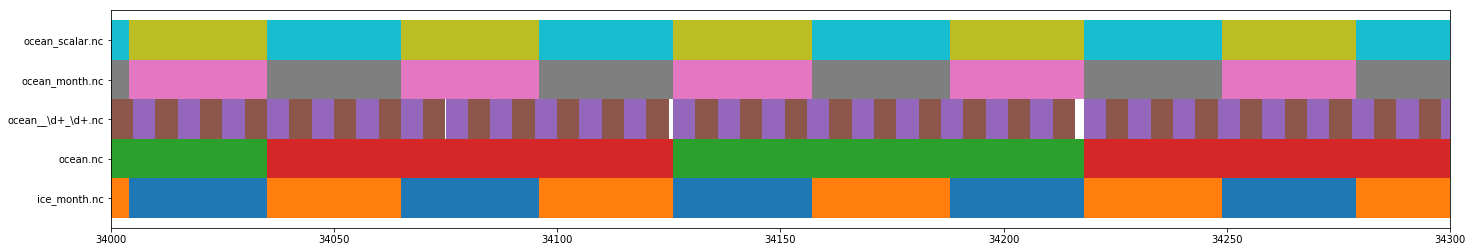

In [106]:
plt.figure(figsize=(24,4))

df = pd.DataFrame(l, columns = ['basename', 'T1', 'DT'])
df = df.sort_values(['basename', 'T1'])
labels = []
for n, g  in enumerate(df.groupby('basename')):
    labels.append(g[0])
    T1 = g[1].T1
    DT = g[1].DT
    plt.barh(n*np.ones_like(DT[::2]), DT[::2], height=1, left=T1[::2])
    plt.barh(n*np.ones_like(DT[1::2]), DT[1::2], height=1, left=T1[1::2])

plt.yticks(range(len(labels)), labels)

plt.xlim(34000, 34300)

matplotlib.pyplot.barh(bottom, width, height=0.8, left=None, hold=None, **kwargs)
Make a horizontal bar plot.

Make a horizontal bar plot with rectangles bounded by:

left, left + width, bottom, bottom + height
(left, right, bottom and top edges)

## bottom topography

In [6]:
ht = cc.get_nc_variable('KDS75', 'ocean_grid', 'ht', n=1)

Found 379 ncfiles
chunking info ('yt_ocean', 'xt_ocean') [675, 900]
using last 1 ncfiles only


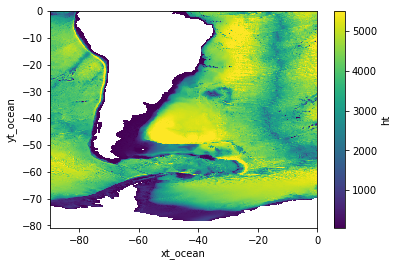

In [7]:
ht.squeeze()\
.sel(xt_ocean=slice(-90, 0), yt_ocean=slice(-90, 0))\
.plot()

We want the 2000m depth contour along the western boundary of the Atlantic ocean.

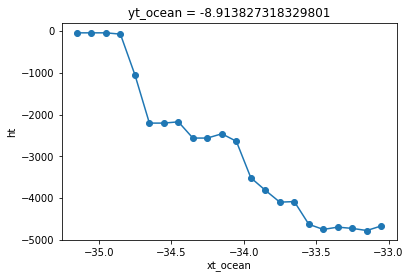

In [67]:
(ht.squeeze()\
.sel(xt_ocean=slice(-60, -33))\
.sel(yt_ocean=slice(-9, -8.9))\
*-1).plot(marker='o')

(-60, -35)

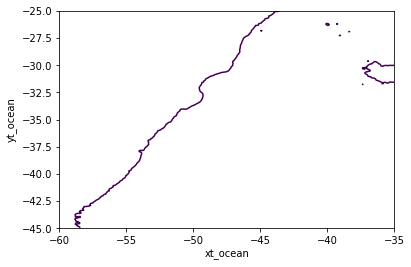

In [8]:
c = ht.squeeze()\
.sel(xt_ocean=slice(-70, -30), yt_ocean=slice(-45, -25))\
.plot.contour(levels=[2000])
plt.ylim(-45, -25)
plt.xlim(-60, -35)

In [9]:
contour = np.vstack([p.vertices for p in c.collections[0].get_paths()])

(-60, -35)

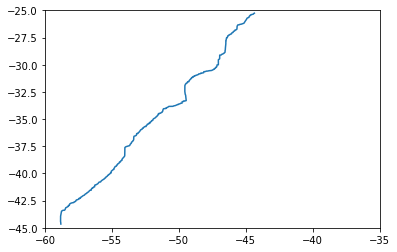

In [10]:
df2 = pd.DataFrame(contour, columns=['x', 'y']).groupby(['y']).min().rolling(15, center=True).min().drop_duplicates()

df = df2.reset_index().dropna()

plt.plot(df.x, df.y)
plt.ylim(-45, -25)
plt.xlim(-60, -35)

In [81]:
df.values

array([[-44.65490349, -58.8124064 ],
       [-44.46794983, -58.82545594],
       [-44.42958301, -58.83440289],
       [-43.92864319, -58.83096389],
       [-43.49400666, -58.76517451],
       [-43.46030253, -58.75      ],
       [-43.38767379, -58.65      ],
       [-43.38682252, -58.55      ],
       [-43.33583747, -58.50143933],
       [-43.16926508, -58.45224085],
       [-43.16142294, -58.45      ],
       [-43.09628791, -58.35      ],
       [-43.02322377, -58.25667267],
       [-42.95007247, -58.25515876],
       [-42.94945641, -58.25      ],
       [-42.9427275 , -58.18236907],
       [-42.80350885, -58.15      ],
       [-42.73009657, -58.05      ],
       [-42.6970666 , -57.95      ],
       [-42.67770165, -57.85174298],
       [-42.6565972 , -57.85      ],
       [-42.58301095, -57.75      ],
       [-42.58031524, -57.71812115],
       [-42.50692347, -57.68242967],
       [-42.43557751, -57.65      ],
       [-42.41193793, -57.55      ],
       [-42.36173035, -57.49740211],
 

In [82]:
ht = cc.get_nc_variable('KDS75', 'ocean_grid.nc', 'ht', n=1)

Found 379 ncfiles
chunking info ('yt_ocean', 'xt_ocean') [675, 900]
using last 1 ncfiles only


In [87]:
dy = 0.05
dx = 0.05
hts = []
for y, x in df.values:
    s = ht.sel(xt_ocean=slice(x-dx, x+dx), yt_ocean=slice(y-dy, y+dy))
    s = s.isel(xt_ocean = 0, yt_ocean=0)
    hts.append(s)

s = xr.concat(hts, dim='s')

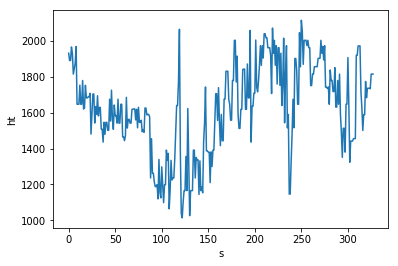

In [88]:
s.plot()

In [46]:
ht.sel(xt_ocean=slice(x-dx, x+dx), yt_ocean=slice(y-dy, y+dy)).values

array([[[ 1098.79174805]]])

In [17]:
def op(variable):
    dy = 0.05
    dx = 0.05
    pot_rhos = []
    for y,x in df.values:
        pot_rho = variable.sel(xt_ocean=slice(x-dx, x+dx), yt_ocean=slice(y-dy, y+dy))
        pot_rho = pot_rho.isel(xt_ocean = 0, yt_ocean=0)
        pot_rhos.append(pot_rho)

    pot_rho = xr.concat(pot_rhos, dim='s')
    return(pot_rho)

In [22]:
pot_rho_2 = cc.get_nc_variable('KDS75', 'ocean__', 'pot_rho_2', n=10, 
                               time_units='days since 1900', op=op)

Found 720 ncfiles
chunking info ('time', 'st_ocean', 'yt_ocean', 'xt_ocean') [1, 7, 300, 400]
using last 10 ncfiles only


In [23]:
pot_rho_2

<xarray.DataArray 'pot_rho_2' (s: 328, time: 10, st_ocean: 75)>
dask.array<concatenate, shape=(328, 10, 75), dtype=float64, chunksize=(1, 1, 7)>
Coordinates:
  * st_ocean  (st_ocean) float64 0.5413 1.681 2.94 4.332 5.869 7.569 9.447 ...
  * time      (time) datetime64[ns] 1998-10-19T12:00:00 1998-10-24T12:00:00 ...
    xt_ocean  (time, s) float64 -58.85 -58.85 -58.85 -58.85 -58.75 -58.75 ...
    yt_ocean  (time, s) float64 -44.68 -44.47 -44.47 -43.97 -43.53 -43.46 ...
    geolon_t  (time, s) float64 -58.85 -58.85 -58.85 -58.85 -58.75 -58.75 ...
    geolat_t  (time, s) float64 -44.68 -44.47 -44.47 -43.97 -43.53 -43.46 ...
Dimensions without coordinates: s
Attributes:
    long_name:      potential density referenced to 2000 dbar
    units:          kg/m^3
    valid_range:    [ -1.00000000e+01   1.00000000e+05]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT

In [26]:
%%time
p = pot_rho_2.isel(time=0).load()

CPU times: user 8.22 s, sys: 328 ms, total: 8.54 s
Wall time: 8.53 s


In [96]:
p1 = pot_rho.isel(time=1).load()

In [117]:
p = [p, p1]

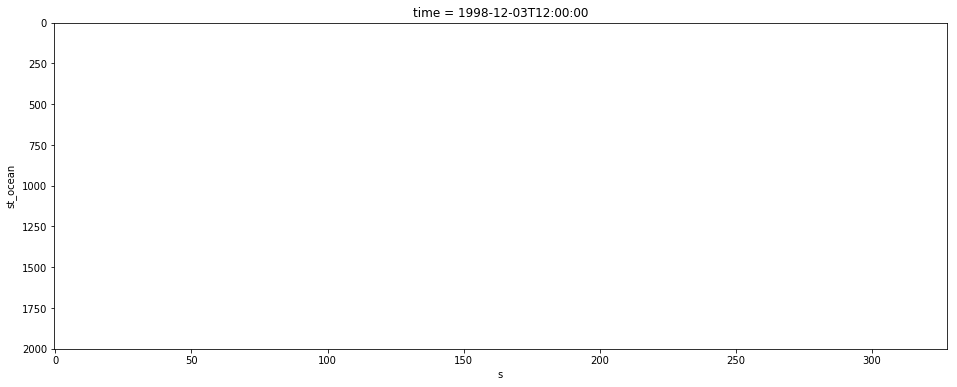

In [27]:
fig = plt.figure(figsize=(16,6))
ax = plt.subplot()

ims = []
for i in tqdm.tqdm_notebook(range(10)):
    p = pot_rho_2.isel(time=i)
    im = p.plot.pcolormesh('s', yincrease=False, add_colorbar=False, ax=ax)
    ims.append([im])

ax.set_ylim(0,2000)
ax.invert_yaxis()

ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=1000)



In [28]:
ani

In [162]:
ax

/g/data3/hh5/public/apps/miniconda3/envs/analysis3/lib/python3.6/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


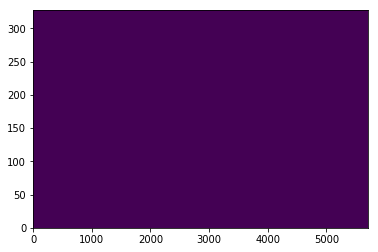

In [153]:
plt.pcolormesh(pp.st_ocean.values, pp.s.values, pp.values)

In [154]:
pp.plot.pcolormesh??

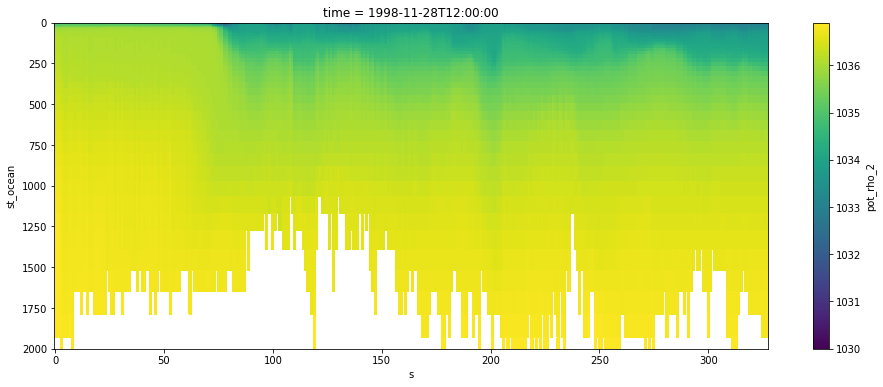

In [123]:
plt.figure(figsize=(16,6))
p[0].plot.pcolormesh('s')
plt.ylim(0,2000)
plt.gca().invert_yaxis()

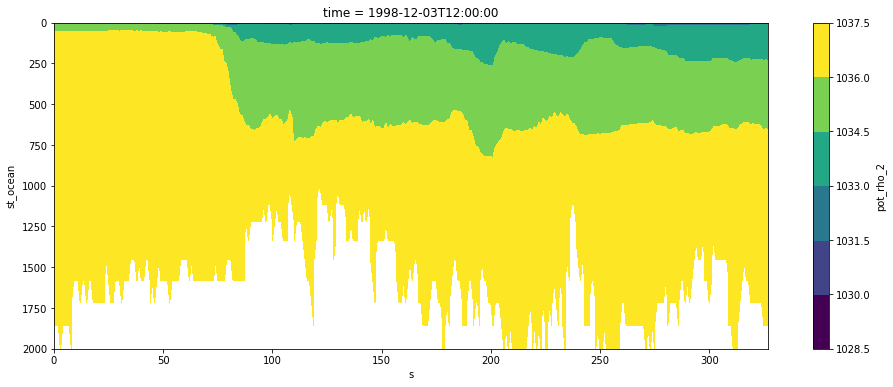

In [112]:
plt.figure(figsize=(16,6))
p1.plot.contourf('s')
plt.ylim(0,2000)
plt.gca().invert_yaxis()

In [147]:
pot_rho_2.sel(xt_ocean=slice(-90, 0), yt_ocean=slice(-90, 0)).isel(st_ocean=0).isel(time=0).plot()

NameError: name 'pot_rho_2' is not defined

Overturning circulation.  Deep water production.

### T-S Plot

### Temperature


In [5]:
temp = cc.get_nc_variable('gfdl_nyf_1080_PI', 'ocean__', 'temp', n=1)
salt = cc.get_nc_variable('gfdl_nyf_1080_PI', 'ocean__', 'salt', n=1)

Using 50 ncfiles
chunking info ('time', 'st_ocean', 'yt_ocean', 'xt_ocean') [1, 10, 216, 288]
Using 50 ncfiles
chunking info ('time', 'st_ocean', 'yt_ocean', 'xt_ocean') [1, 10, 216, 288]


In [27]:
temp.data.numblocks

(1, 5, 5, 5)

In [7]:
def handle(x):
    return (x.flatten())

In [11]:
blocksize = 10*216*288

In [32]:
T = temp.data.map_blocks(lambda x: x.flatten(), chunks=(10*216*288,),drop_axis=[0,1])


ValueError: Can't drop an axis with more than 1 block. Please use `atop` instead.

In [15]:
T = temp.data[0, 0:10, 0:216, 0:288].compute().flatten()
S = salt.data[0, 0:10, 0:216, 0:288].compute().flatten()

In [16]:
blocksize = len(T)

In [17]:
df = pd.DataFrame({'T': T, 'S' : S }, 
                    index =np.arange(blocksize))

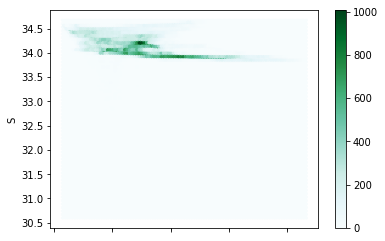

In [18]:
df.plot.hexbin('T', 'S')

In [54]:
10*216*288

622080

In [29]:
T = temp.data.reshape(-1)
S = salt.data.reshape(-1)

In [34]:
1080 * 1440

1555200

In [30]:
import dask.dataframe as dd

dask.array<reshape, shape=(77760000,), dtype=float64, chunksize=(1555200,)>

In [6]:
ts = xr.Dataset({'temp':temp, 'salt':salt})

In [10]:
ts.temp.data.to_dataframe()

AttributeError: 'Array' object has no attribute 'to_dataframe'

In [7]:
df = ts.to_dataframe().dropna()

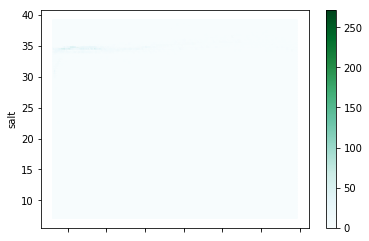

In [22]:
df.sample(10000).plot.hexbin(x='temp', y='salt', gridsize=200)

Here is the 0.25$^\circ$ model output:

Here are the experiments with in the APE-MOM configuration:

In [5]:
rows = db.query('SELECT DISTINCT experiment from ncfiles where configuration = "APE-MOM" ')
expts = [row['experiment'] for row in rows]
print(expts)

['gfdl_nyf_1080_cp', 'gfdl_nyf_1080_UP', 'gfdl_nyf_1080_SH', 'gfdl_nyf_1080_PI']


Here the variables saved:

In [6]:
rows = db.query('SELECT experiment, count(variable) '
                'FROM (select distinct experiment, variable from ncfiles '
                'WHERE configuration = "APE-MOM") '
                'GROUP BY experiment')
print ('{:17}'.format('Experiment'), 
       '{:13}'.format('Num Variables'))
for row in rows:
    print ('{:17}'.format(row['experiment']), 
           '{:13}'.format(row['count(variable)']))

Experiment        Num Variables
gfdl_nyf_1080_PI            139
gfdl_nyf_1080_SH            139
gfdl_nyf_1080_UP            139
gfdl_nyf_1080_cp            143


In [9]:
rows = db.query('SELECT DISTINCT variable '
                'FROM ncfiles '
                'WHERE configuration = "APE-MOM" '
                'AND experiment = "gfdl_nyf_1080_PI" '
               )
for row in rows:
    print(row['variable'])
print()

xt_ocean
yt_ocean
time
nv
xu_ocean
yu_ocean
st_ocean
st_edges_ocean
sw_ocean
sw_edges_ocean
geolon_t
geolat_t
geolon_c
geolat_c
u
v
net_sfc_workq
net_sfc_workemp
pot_rho_diff_cbt
pot_rho_diff_cbt_conv
pot_rho_advect
pot_rho_submeso
pot_rho_sbc
pot_rho_kpp_nloc
pot_rho_frazil
pot_rho_tendency
wt
pot_rho_2
dzt
tau_x
tau_y
average_T1
average_T2
average_DT
time_bounds
xt
xb
yt
yb
ct
CELL_AREA
COSROT
GEOLAT
GEOLON
SINROT
ALB
CN
EXT
EXT_min
EXT_max
HI
HS
LH
LW
SH
SSH
SSS
SST
SW
ht
hu
area_t
area_u
kmt
kmu
drag_coeff
rhobin
rho_z_trans_south
rho_z_trans_north
scalar_axis
ke_tot
pe_tot
temp_global_ave
salt_global_ave
rhoave
temp_surface_ave
salt_surface_ave
total_ocean_salt
total_ocean_heat
eta_global
total_volume_seawater
total_ocean_sfc_salt_flux_coupler
total_net_sfc_heating
total_ocean_pme_river
total_ocean_river
total_ocean_runoff
total_ocean_calving
total_ocean_melt
total_ocean_evap
total_ocean_lprec
total_ocean_fprec
total_ocean_runoff_heat
total_ocean_calving_heat
total_ocean_river_hea

In [96]:
pot_rho_2 = cc.get_nc_variable('KDS75', 'ocean__', 'pot_rho_2', 
                            time_units='days since 2000', 
                               op = lambda x: x.sel(st_ocean=slice(300,330), 
                                                    yt_ocean=slice(-60,-10), 
                                                    xt_ocean=slice(-70,-20)),
                               n=72)

Found 720 ncfiles
chunking info ('time', 'st_ocean', 'yt_ocean', 'xt_ocean') [1, 7, 300, 400]
using last 72 ncfiles only


In [34]:
pot_rho_2.isel(time=0)

<xarray.DataArray 'pot_rho_2' (st_ocean: 1, yt_ocean: 654, xt_ocean: 500)>
dask.array<getitem, shape=(1, 654, 500), dtype=float64, chunksize=(1, 110, 300)>
Coordinates:
  * xt_ocean  (xt_ocean) float64 -69.95 -69.85 -69.75 -69.65 -69.55 -69.45 ...
  * yt_ocean  (yt_ocean) float64 -60.0 -59.95 -59.9 -59.85 -59.8 -59.75 ...
  * st_ocean  (st_ocean) float64 312.4
    time      datetime64[ns] 1998-10-19T12:00:00
    geolon_t  (yt_ocean, xt_ocean) float64 -69.95 -69.85 -69.75 -69.65 ...
    geolat_t  (yt_ocean, xt_ocean) float64 -60.0 -60.0 -60.0 -60.0 -60.0 ...
Attributes:
    long_name:      potential density referenced to 2000 dbar
    units:          kg/m^3
    valid_range:    [ -1.00000000e+01   1.00000000e+05]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT

In [101]:
fig = plt.figure(figsize=(8,8))
ax = plt.subplot()

ims = []
for i in tqdm.tqdm_notebook(range(72)):
    p = pot_rho_2.isel(time=i).squeeze()
    im = p.plot.pcolormesh(add_colorbar=False, ax=ax)
    ts = pd.to_datetime(str(pot_rho_2.time[i].values)).strftime('%y/%m/%d') 

    t = ax.text(-65, -20, ts, color='black', size=18)
    ims.append([im, t])

ax.set_title('pot_rho_2 at st_ocean={:.0f} m'.format(pot_rho_2.st_ocean.values[0]))
ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=1000)

plt.close(fig)

In [102]:
ani

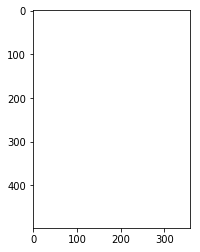

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import rc
rc('animation', html='html5')

fig = plt.figure()

def f(x, y):
    return np.sin(x) + np.cos(y)

x = np.linspace(0, 2 * np.pi, 120)
y = np.linspace(0, 2 * np.pi, 100).reshape(-1, 1)
# ims is a list of lists, each row is a list of artists to draw in the
# current frame; here we are just animating one artist, the image, in
# each frame
ims = []
for i in range(60):
    x += np.pi / 15.
    y += np.pi / 20.
    data = pot_rho_2.isel(time=-i, st_ocean=25)\
         .sel(xt_ocean=slice(-60, 30))\
         .sel(yt_ocean=slice(-90,0))
    im = plt.imshow(data, animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=1000)

# ani.save('dynamic_images.mp4')
rc('animation', html='html5')


In [16]:
ani

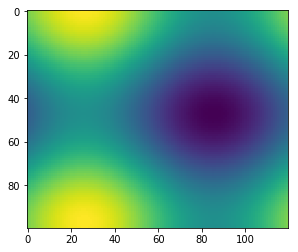

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

fig = plt.figure()


def f(x, y):
    return np.sin(x) + np.cos(y)

x = np.linspace(0, 2 * np.pi, 120)
y = np.linspace(0, 2 * np.pi, 100).reshape(-1, 1)

im = plt.imshow(f(x, y), animated=True)


def updatefig(*args):
    global x, y
    x += np.pi / 15.
    y += np.pi / 20.
    im.set_array(f(x, y))
    return im,

ani = animation.FuncAnimation(fig, updatefig, interval=50, blit=True)
plt.show()

In [10]:
ani

In [11]:
u = cc.get_nc_variable('gfdl_nyf_1080_PI', 'ocean__', 'u',
                           time_units = 'days since 1600-01-01', n = 10)

Using 3650 ncfiles
chunking info ('time', 'st_ocean', 'yu_ocean', 'xu_ocean') [1, 10, 216, 288]


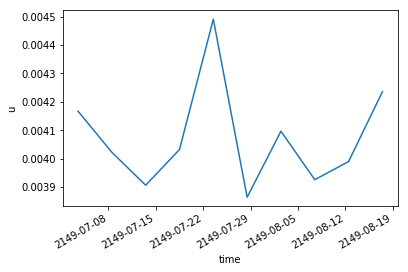

In [14]:
u.mean('xu_ocean').mean('yu_ocean').mean('st_ocean').plot()

In [15]:
u.time

<xarray.DataArray 'time' (time: 10)>
array(['2149-07-03T12:00:00.000000000', '2149-07-08T12:00:00.000000000',
       '2149-07-13T12:00:00.000000000', '2149-07-18T12:00:00.000000000',
       '2149-07-23T12:00:00.000000000', '2149-07-28T12:00:00.000000000',
       '2149-08-02T12:00:00.000000000', '2149-08-07T12:00:00.000000000',
       '2149-08-12T12:00:00.000000000', '2149-08-17T12:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2149-07-03T12:00:00 2149-07-08T12:00:00 ...
Attributes:
    long_name:      time
    decoded_using:  days since 1600-01-01

In [18]:
ds.pot_rho_2(xt_ocean=0)

TypeError: 'DataArray' object is not callable

In [53]:
%%time
for case, expt in expts.items():
    print(case)
    ncfiles = expt['path'] + '/output*/ocean__*.nc'
    expt['dsx'] = xr.open_mfdataset(ncfiles, decode_times=False, concat_dim='time',
                                   chunks = chunks, drop_variables=drop_variables)

SH


OSError: Too many open files

In [ ]:
xr.open_mf